<a href="https://colab.research.google.com/github/thotran2015/6.871/blob/master/Problem_1_(Student_Version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1: Interpretability for Internal Validity with MIMIC-CXR
## Overview
In this problem, we'll work with the [`MIMIC-CXR`](https://physionet.org/content/mimic-cxr/2.0.0/) dataset, which contains chest X-rays and radiology reports for approximately 230k radiological studies at Beth Israel Deacones Medical Center. The full dataset is accessible in two formats, one in [DICOM format](https://physionet.org/content/mimic-cxr/2.0.0/) with the full, de-identified free-text radiology reports, and one in a preprocessed, compressed [JPG format](https://physionet.org/content/mimic-cxr-jpg/2.0.0/) with structured labels derived from the radiology reports. We will provide you with preprocessed data so you do not need to worry about working with the DICOM format here.

## Data Access
### Sign the DUA
To access our provided files in the cloud, first you must sign the `MIMIC-CXR` JPG and DICOM DUAs. You can do so by
  1. Logging into Physionet
  2. Navigating to the MIMIC-CXR JPG page, here: https://physionet.org/content/mimic-cxr-jpg/2.0.0/, then
  3. Scrolling down to the bottom of the page, then clicking the "[sign the data use agreement](https://physionet.org/sign-dua/mimic-cxr-jpg/2.0.0/)" link under the "Files" header, and agreeing to the DUA on the subsequent page. 
  4. Navigating to the MIMIC-CXR DICOM page, here: https://physionet.org/content/mimic-cxr/2.0.0/ then
  5. Scrolling down to the bottom of the page, then clicking the "[sign the data use agreement](https://physionet.org/sign-dua/mimic-cxr/2.0.0/)" link under the "Files" header, and agreeing to the DUA on the subsequent page.

### GCP Access
Navigate to the [MIMIC-CXR](https://physionet.org/content/mimic-cxr/2.0.0/) Files section, and click "Request access the files using Google Cloud Storage Browser"
  
## Our Task
A colleague comes to you with a model they've trained to take chest X-rays and diagnose whether or not the patient has [Pneumothorax](https://www.mayoclinic.org/diseases-conditions/pneumothorax/symptoms-causes/syc-20350367#:~:text=A%20pneumothorax%20(noo%2Dmoe%2D,a%20portion%20of%20the%20lung.). The performance obtained by this model is good, but your colleague is concerned the model may be abusing unintended confounders in the dataset to artificially increase performance. Hearing that you're an expect in machine learning for health, they've come to you to help diagnose whether or not there is any problem.

We'll provide you access to their pre-trained model (so you won't need to do any training of CNNs on large image datasets for this assignment), along with a test set of patients unseen during training for use in evaluating the model. You will access these files through the PhysioNet interface in the manner of week 1. Using these tools, your job will be to assess whether their model is learning a clinically actionable signal for use in diagnostics, or is leveraging any unintended counfounders or label leakage to make its predictions.

One critical tool we'll explore in depth to assess the suitability of these models for deployed use is interpretability methods, which can be a valuable tool to assess the internal validity of the model -- you may recall this is a concept we saw Dr. Rahul Deo explore in [the video](https://youtu.be/UVUq0-32iHw) you watched for reflection readings in week 1.

We recommend you **do not** use a CUDA enabled runtime with this problem -- it will not be necessary as you only sparingly need to run the model, and may cause more issues w.r.t. CUDA memory and quota if you do.

## Outline
In the rest of this notebook, we will
  1. **Imports & Boilerplate:** Define some boilerplate code, do imports, define constants, etc. Additionally, here you will run the authentication and file transfer code to move the provided files to your colab runtime from our credentialed GCP bucket. Note that you will not be able to do this if you have not activated your account for both cloud and MIMIC-CXR access on Physionet by signing the appropriate DUAs (this takes no more than a few clicks).
  2. **Basic Profiling:** Do basic profiling of the datasets and model. You won't need to do any coding here, just run the provided cells and analyze the cell's outputs.
  3. **Interpretability Analysis:** 
    1. Error Auditing: In this section, our first task will be to do what is known as "Error Auditing," in which we examine random subsets of images from each quadrant of our confusion matrix, and attempt to discern any patterns that may be driving model performance. While we _strongly_ encourage you to attempt to do this analysis on your own, we will ultimately provide you the interpretation we are concerned about in this analysis, to standardize later parts as we dive into these methods more and so that we can offer the relevant clinical background knowledge to help explain why what we observe is or isn't problematic. There will be some questions on this section you'll need to include in your writeup.
    2. Saliency Map & GradCAM: Next, we'll use interpretability methods, in particular, Saliency Maps and GradCAM, to validate our intuition, taking these same images from each quadrant of the confusion matrix and highlighting which regions of the image the network is most reliant upon when making its predictions. Here, you will need to implement key pieces of the relevant algorithm, which we will describe to you beforehand. There will be some questions on this section you'll need to include in your writeup.
    3. Validation of Hypothesis Using Reports: Finally, we'll quantify this instinct identified on a random subset of images across the whole test set. In particular, we'll leverage the free-text reports to examine Radiologists commentary on these images, and see if any information we can extract from those comments can confirm or dispute our hypotheses about the source of the model's performance. There will be some questions on this section you'll need to include in your writeup.
    4. Performance Discrepancies: Ultimately, you'll run a final test to determine the impact a particular confounder might be having on our results -- namely, once more leveraging the reports, you'll split the provided dataset into multiple stratified subsets, then ask how performance varies from the overall model across these subsets. Seeing a large impact will imply that the stratification process captures a significant part of what the model uses to make its predictions. There will be some questions on this section you'll need to include in your writeup.
  4. **Final Discussion:** Draw conclusions about whether or not this model is learning using a valid, actionable clinical pathway, or rather using unintended confounders. There will be some questions on this section you'll need to include in your writeup.

## Imports & Boilerplate

In [0]:
from skimage.transform import resize
import json, os, pickle, matplotlib.pyplot as plt, numpy as np, pandas as pd
import torch, torchvision, torch.nn as nn, torch.optim as optim

from tqdm import tqdm_notebook as tqdm
from random import randint
from sklearn.model_selection import train_test_split
from imageio import imread
from collections import Counter
from google.colab import auth
from imageio import imread
from PIL import Image
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.utils.data._utils.collate import default_collate
from torchvision import models, transforms
from sklearn.metrics import roc_auc_score
from math import floor, sqrt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

%matplotlib inline

auth.authenticate_user()

In [0]:
RANDOM_STATE = 5
NUM_SAMPLES = 4

In [18]:
!gsutil cp gs://mlhc2020_pset3_problem1/evaluation_set.csv ./
!gsutil cp gs://mlhc2020_pset3_problem1/state_dict.torch ./

evaluation_set = pd.read_csv('evaluation_set.csv', index_col='study_id')

Copying gs://mlhc2020_pset3_problem1/evaluation_set.csv...
/ [1 files][165.7 KiB/165.7 KiB]                                                
Operation completed over 1 objects/165.7 KiB.                                    
Copying gs://mlhc2020_pset3_problem1/state_dict.torch...
- [1 files][ 56.2 MiB/ 56.2 MiB]                                                
Operation completed over 1 objects/56.2 MiB.                                     


In [0]:
%%time
# Load the jpgs.
!gsutil cp gs://mlhc2020_pset3_problem1/jpgs.zip ./
!unzip jpgs.zip

Copying gs://mlhc2020_pset3_problem1/jpgs.zip...
| [1 files][556.7 MiB/556.7 MiB]                                                
Operation completed over 1 objects/556.7 MiB.                                    
Archive:  jpgs.zip
replace files/p17/p17872769/s51155022/934e9efb-480733fc-0aed0e90-ee371203-da13c4a1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Model / Class / Helper Function Definitions

We'll be working with some pre-defined models & code this week -- you won't need to modify the model code; however, it is still a good idea to read through it and see if you can follow the logic. Nothing in the cells in this section will require modification from you.

In [0]:
def display_study(study_id, overall_dataframe=evaluation_set, S = 15):
    """
    This cell displays a particular "study" on a patient from the passed
    dataframe, initialized to be the `evaluation_set` provided. There's not
    much to this function--it simply loads the record, prints out some metadata
    and the cell's report, then displays the grayscale image after loading it
    from disk.
    """

    # Get the record
    record = overall_dataframe.loc[study_id]
    report = record.report
    jpg_path = record.jpg_path
    label = record.Pneumothorax

    # Print some metadata (Pneumothorax label) and the study's report
    print(
        "Study %s has pneumothorax label %s"
        "" % (str(study_id), str(label))
    )
    print(report)

    # Plot the x-ray.
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(S, S))
    
    try: xray = imread(jpg_path)
    except OSError as e:
        print(
            "Can't read jpg: %s\n"
            "Received error: %s"
            "" % (jpg_path, e)
        )
        print("Continuing.")
        fig.clear()
        return
    
    ax.imshow(xray, cmap='gray')
    display(fig)

    # We call fig.clear() here as we've already displayed it above, and clearing
    # it will keep colab from displaying it twice.
    fig.clear()
    return None

class SimpleDataset(Dataset):
    """
    This is our Dataset class. Like last week, this class will need to compute
    the length of its underlying data (in this case, the length of the passed
    dataframe), and implement logic to retrieve and tensorify a given sample.
    """
    def __init__(self, dataframe, label_col = 'Pneumothorax', Ts = None):
        self.dataframe = dataframe
        self.label_col = label_col
        if Ts is None: Ts = []

        # These transforms are commonly used in computer vision pipelines to 
        # standardize inputs, both in the normal sense (e.g., mean and std),
        # but also with more specific image-focused manners (e.g., resizing,
        # cropping, etc.). See
        # https://pytorch.org/docs/stable/torchvision/transforms.html for more
        # information.
        self.transform = transforms.Compose(
            Ts + [
                transforms.Resize(256),
                transforms.CenterCrop(256),
                transforms.ToTensor(),
                transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
    
    def get_batch(self, study_ids):
        """
        We use this helper function to convert a list of normal study_ids into
        a tensorized batch. It will be used later in our interpretability section.
        """
        indices = np.arange(len(self))[self.dataframe.index.isin(study_ids)]
        return default_collate([self[i] for i in indices])

    def __len__(self): return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Retreive the record at this index.
        record = self.dataframe.iloc[idx]
        
        # Load the image from disk. We do this each time because storing the
        # image data in memory would be prohibitively expensive. Of course,
        # this merely trades time for space, as reading from disk takes a long
        # time, but luckily we can parallelize around that by using a DataLoader
        # with many workers and/or by using a large batch size to concentrate
        # work. Caching could also be used here to speed this up, but it isn't
        # necessary in our use-case.
        path = record['jpg_path']
        img = imread(path)

        # Turn the image from a numpy array to a PIL image, then apply our
        # transforms. PIL is very commonly used for image processing in python;
        # if you're not familiar, see here:
        # https://pillow.readthedocs.io/en/stable/
        image = Image.fromarray(img)
        image = self.transform(image)
        
        # Get the label.
        label = torch.FloatTensor([record[self.label_col]])
        
        return image, label

class SimpleModel(nn.Module):
    """
    This is our simple classification model. It loads a pre-trained CNN model
    (one of the classes below), then uses all but the last two layers, followed
    by max pooling and a narrow, 2-hidden layer fully connected network to
    perform binary classification.
    """

    # This structure maps strings to different torchvision model classes. You
    # can change the modeltype passed to the constructor to build a different
    # model. The format is:
    # {name: (constructor, output_channels)}
    MODELS = {
        "resnet18": (models.resnet18, 8),
        "vgg16_bn": (models.vgg16_bn, 8),
    }

    def __init__(
        self, use_cuda=torch.cuda.is_available(), freeze_cnn=False,
        pretrained=True, model_name="resnet18",
    ):
        """
        Our simple CNN's constructor. Most of these parameters are only changed
        during training, and shouldn't be modified here.
        `use_cuda`: Whether or not to use cuda.
        `freeze_cnn`: Freeze the pre-trained CNN so we only update the
                      classifier
        `pretrained`: Whether or not the CNN encoder should be pretrained
        `model_name`: What kind of CNN to use.
        """
        super().__init__()
        self.use_cuda = use_cuda

        # Build our CNN encoder.
        cnn_cstr, out_dim = SimpleModel.MODELS[model_name]
        cnn = cnn_cstr(pretrained=pretrained)

        # We take all but the last two layers as our encoder stack.
        cnn_modules = list(cnn.children())[:-2]

        # Build up the module that converts an image into a fixed-size feature
        # vector. We call it `self.features` to stay true to `torchvision` 
        # semantics.
        self.features = nn.Sequential(*cnn_modules)

        if freeze_cnn: self.features.requires_grad = False
        
        # This is our classifier layer -- it ingests the features coming out of
        # the CNN encoder (out of `self.features`) and returns a logit for our
        # binary classification task.
        self.classifier = nn.Sequential(
            nn.Linear(out_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )
        
        # We'll use these to construct output probabilities and the output loss.
        self.sigmoid = nn.Sigmoid()
        self.loss_fn = nn.BCEWithLogitsLoss()
    
    # These methods are going to be useful in our interpretability methods,
    # where, for GradCAM, we'll want to store the gradients of our loss with
    # respect to the last convolutional layer, and we'll use these to
    # accomplish that.
    def save_grads(self, g): self.gradients = g
    def get_grads(self): return self.gradients
    def get_conv_out(self, x): return self.features(x)

    def forward(self, x, y):
        # Convert the batch to CUDA if necessary.
        if self.use_cuda: x, y = x.cuda(), y.cuda()
            
        # Acquire our featurized input
        conv_out = self.features(x)
        if conv_out.requires_grad: h = conv_out.register_hook(self.save_grads)

        # Max-pool across the whole image to get a fixed-size representation.
        conv_out_pooled = conv_out.max(dim=1)[0].max(dim=1)[0]

        # Compute our final logit.
        score = self.classifier(conv_out_pooled)
        prob = self.sigmoid(score)
        loss = self.loss_fn(score, y)
            
        return score, prob, loss
    
def eval_model(val_dataset, model, batch_size = 1024):
    """
    This function should look very familiar from last week -- it merely runs over
    the provided dataset and computes the overall performance of the model.
    """
    
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=16
    )
    num_val_batches = len(val_dataloader)

    model.eval()
    val_batches = tqdm(
        val_dataloader, total=num_val_batches, leave=False, desc="Val Batch"
    )
    val_probs, val_probs_flat = [], []
    val_labels, val_labels_flat = [], []
    val_loss = 0
    for batch in val_batches:
        with torch.no_grad():
            _, probs, loss = model(*batch)
            val_loss += loss.detach().cpu().numpy()
            probs = list(probs.detach().cpu().numpy())
            labels = list(batch[-1].detach().cpu().numpy())
        val_probs.extend(probs)
        val_labels.extend(labels)

    val_loss /= num_val_batches
    val_auc = roc_auc_score(val_labels, val_probs)

    return val_loss, val_auc, val_probs

In [0]:
# As we do no training here, we just need one dataset.
dataset = SimpleDataset(evaluation_set)

# In the way of PyTorch, we initialize our model anew, then load the provided
# state dict.
model = SimpleModel(model_name='vgg16_bn')
if torch.cuda.is_available():
  model.load_state_dict(torch.load('./state_dict.torch'))
  model = model.cuda()
else:
  # If for some reason you don't want to use a GPU enabled runtime here. For
  # this assignment, GPUs honestly aren't strictly speaking necessary, though
  # they will still make things faster.
  model.load_state_dict(torch.load(
      './state_dict.torch', map_location=torch.device('cpu')
  ))
model.eval();

## Basic Profiling

Now that we've set up (most of) our boilerplate code, time to actually start to approach our task here. Recall that we want to see if the provided model is actually performing well at the task of Pneumothorax detection, and if we should consider it as ready to move forward in the deployment process. A big risk with _all_ MLHC models is the risk that their performance will largely be driven by external confounders, so that is our primary concern here---namely, that perhaps some other factor in the data, strongly correlated with Pneumothorax, but in a causally inappropriate sense, could be driving our apparent performance. Of course, the model could also just not perform well, so our first tasks will be to, #1 - Inspect the actual data, which is _always_ our step 1, then #2, to see how well the model does perform.

At the end of this section, we'll ask you two questions about the data/model profiling results, which you should include in your final write-up.

### Dataset Profiling
To profile the data here, we'll
  1. See how much evaluation data we've been provided,
  2. Quantify the relative class imbalance is,
  3. Examine a few random cases to see if get a broader feel for the data.

Note that in a real project, you'd want to do more than just this bare minimum of data exploration -- for example, look into the statistics of the reports, quantify whether any of the images show signs of being in the wrong format or orientation, etc. We'll do some of that later in our interpretability analysis, but it is good to keep in mind that you'd really want to do more here for a real project.

In [0]:
N = len(evaluation_set)
print(
    "Our evaluation set contains %d data points, with %.2f%% having "
    "Pneumothorax according to our labels.\n"
    "Sample Data:" 
    "" % (N, 100*evaluation_set.Pneumothorax.mean())
)
display(evaluation_set.head())

So, our data is relatively small (this is intentional, as we've provided you with a limited dataset here only for evaluation purposes) and has minimal class imbalance. This would be a little strange, actually, in the real world -- very few medical conditions are had by 50% of your patients, so this relative balance already suggests some data tampering. In this case, this is intentional on our part, to give you ample data of all labels to explore.

Let's look at a few cases:

In [0]:
np.random.seed(RANDOM_STATE)
N_cases = 20

for study_id in evaluation_set.iloc[np.random.choice(N, N_cases)].index:
    display_study(study_id, S = 7);
    print('\n\n\n\n')

We can see these radiology reports are highly structured, with the sections filled in with free-text language, and the images are in slightly varying positions, but appear to (and have, by us) been standardized to only one view position--namely, front (as opposed to visualizing the patient from the side).

### Model Profiling

Now that we've explored the data briefly, let's actually see how well the model itself does.

In [0]:
loss, auc, probabilities = eval_model(dataset, model, batch_size=64)

# We'll also add the probabilities and predictions here so we can use them
# later
evaluation_set['prob'] = [p[0] for p in probabilities]
evaluation_set['pred'] = (evaluation_set['prob'] > 0.5).astype(float)

print("Model obtains AUROC of %.2f" % (100*auc))

#### Write-up Questions:
1. Do you think this AUROC is good, or bad? If you saw this on a model used to treat patients, how would you feel about that?
2. What about the data itself? If you explore some other cases, do you spot any oddities in the data? Are any images particularly strange, for example, or do any of the reports seem to disagree with the labels? Often, in medical applications, labels can be algorithmically deteremined, which means they may be noisy, and it is important to have a sense (or even better, an outright measure) for how noisy your labels are.

## Interpretability Analysis
In this section, now that we've validated that the model does perform reasonably well at all, we'll dive into the real task at hand -- determining if the model is really likely drawing on a causally appropriate signal of Pneumothorax, or instead may be relying on an inappropriate confounder. We'll start with a basic technique; namely, error auditing, in which we inspect various classes of errors by hand and see if we spot any apparent patterns. Guided by these (or, in this case, the final interpretation we give you), we'll then move on to visualizing what facets of the input image are driving the model to make its prediction via saliency maps and class activation maps, which you'll need to (partially) implement here. Finally, we'll leverage the reports to do some additional analysis of similiarities across the positive predicted images and negative predicted images via some basic natural language processing that you'll also implement. Your main deliverable for this section will be your code, which you'll need to submit as usual, along with some specific answers to questions throughout.

### Examining the Images via Error Auditing

In this section, we'll do some basic error auditing--we'll look at some images in each quadrant of the confusion matrix -- true positives, true negatives, false positives, and false negatives, and try to see if we can make sense of what the model might be using to predict.

In [0]:
true_positives  = evaluation_set[
    (evaluation_set['pred'] == 1) & (evaluation_set['Pneumothorax'] == 1)
].sample(NUM_SAMPLES, random_state=RANDOM_STATE)

false_positives = evaluation_set[
    (evaluation_set['pred'] == 1) & (evaluation_set['Pneumothorax'] == 0)
].sample(NUM_SAMPLES, random_state=RANDOM_STATE)

false_negatives = evaluation_set[
    (evaluation_set['pred'] == 0) & (evaluation_set['Pneumothorax'] == 1)
].sample(NUM_SAMPLES, random_state=RANDOM_STATE)

true_negatives  = evaluation_set[
    (evaluation_set['pred'] == 0) & (evaluation_set['Pneumothorax'] == 0)
].sample(NUM_SAMPLES, random_state=RANDOM_STATE)

In [0]:
for n, quadrant in [
  ('True Positives', true_positives),
  ('False Positives', false_positives),
  #('True Negatives', true_negatives),
  #('False Negatives', false_negatives),
]:
  print('\n\n', "%s: %d" % (n, len(quadrant)))
  for study_id in quadrant.index: display_study(int(study_id))

In [0]:
for n, quadrant in [
  #('True Positives', true_positives),
  #('False Positives', false_positives),
  ('True Negatives', true_negatives),
  ('False Negatives', false_negatives),
]:
  print('\n\n', "%s: %d" % (n, len(quadrant)))
  for study_id in quadrant.index: display_study(int(study_id))

#### Write-up Questions:
3. What do you think the model is using to make its predictions here? Do you see any commonalities (i.e., undesired confounders) among the positive predicted images not shared by the negative predicted images (regardless of the validity of that prediction)?

### One Serious Concern

One serious concern is that the model may not be diagnosing Pneumothorax at all, but instead largely relying on a treatment-based confounder, such as the presence of a "[pigtail cathater](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3015347/)", a small-bore tube used in the case of pneumothorax to allow reinflation of the lung or escape of air from the pleural space (note that pigtail cathaters have numerous other uses as well, but this is the use case of interest to us here), or a chest tube. Both of these are very evident on an x-ray, and are strong indicators that the patient did at one time have Pneumothorax; however, predicting them offers no diagnostic benefit to us as they are only seen if the Pneumothorax is already known and under treatment. For the rest of our analyses, we'll focus on trying to determine if this is the case or not. First, we'll look at interpretability analyses via Saliency maps and Class Activation Maps, then we'll look to see if words for pneumothorax treatments are up-weighted in our positive label set of reports, and finally we'll separate our evaluation dataset into a cohort with a chest drain or pigtail catheter mentioned in their report vs. those without, and see how much the AUROC's differ.

### Saliency Maps & Class Activation Maps

#### Saliency Maps
A class [saliency map](https://arxiv.org/pdf/1312.6034v2.pdf) is one of the simplest mechanisms of interpreting a network, and one of the most widely used. In essence, the gradient based class saliency map answers the following question:
  > Which features in my input, if you changed them independently of any others, would affect my predicted output most?

You can see the appeal of answering this question -- if some regions of our input images here don't matter at all, we'd like to be able to see which regions those are. Conversely, if certain pixels are very informative to the loss, we'd like to know that too. The way saliency maps answer this question is also very straightforward, they simply compute the gradient of the loss of the network with respect to the input image of the network, then visualize these gradients as a heatmap over the image. This quantifies directly how much changing any pixel in isolation would affect your output prediction (in a sufficiently locla region around the given image, at least).

We'll require you to fill in some critical pieces of the function `get_saliency` below.

In [0]:
def get_saliency(
    model, study_ids, dataset=dataset, use_cuda=torch.cuda.is_available(),
):
    """
    Source Paper: https://arxiv.org/pdf/1312.6034v2.pdf

    This function will compute the saliency (the max-over-channels per-pixel
    derivative of the final logit with respect to the input image) of the
    model for each image in the studys passed in `study_ids`, within `dataset`.
    Note that normally you need to do something clever to control which class
    label you most want to affect, but as our task is binary classification and
    thus our labels are linearly related (as their probabilities must sum to one),
    we can simply capture overall magnitude of gradients here.
    
    Inputs:
    `model`: The model to use to compute the saliency map.
    `study_ids`: The study_ids to show
    `use_cuda`: Use CUDA or not.
    """
    # First we conver the `study_ids` into an actual tensorized batch.
    images, labels = dataset.get_batch(study_ids)
    if use_cuda: images, labels = images.cuda(), labels.cuda()
    # Images is of shape [batch, channels, dim_1, dim_2]

    ## TODO: Task #1 #############################################################
    #                                                                            #
    # Compute the saliency values here, and store them in a variable called      #
    # `saliency` (this is returned at the end of the function).                  #
    # You need to:                                                               #
    #   1. Ensure the model knows it needs to differentiate all the way through  #
    #      to the input images. **Hint:** See                                    #
    #  https://pytorch.org/docs/stable/tensors.html#torch.Tensor.requires_grad_  #
    #   2. Compute the logits corresponding to these images. For this, you just  #
    #      need to run the model on the batch of images and labels.              #
    #      when you do so, also store the probabilities output from the model in #
    #      a variable called `probs` which we return at the end of the function. #
    #   3. Differentiate through these logits. In PyTorch you can do this        #
    #      simply by calling `backward()` on a tensor, and derivatives will be   #
    #      computed for all of its children that require gradients. Recall that  #
    #      we must either provide logits.backward() with a vector to use in the  #
    #      vector-jacobian product, or convert it to a scalar. There are two     #
    #      natural approaches here. One would be to pass in a vector containing  #
    #      a "1" at each position corresponding to an image whose label was 1,   #
    #      and a "-1" everywhere else. This would give us the gradient scaled by #
    #      the true label, such that moving in the direction of the pixel        #
    #      gradient would most increase the probability of the true label.       #
    #      If we were to use gradient per-pixel direction (e.g., sign) in our    #
    #      display code, this would offer a more informed view of our model's    #
    #      interpretation. However, that is *not* what we'll do here. Instead,   #
    #      we will *ignore* directionality, and simply ask which pixels, when    #
    #      perturbed, most affect the output in either direction. So, it won't   #
    #      matter to us what the sign of the gradient is, so we can use the      #
    #      other forementioned reasonable approach -- namely, we'll just pass a  #
    #      vector of all 1s, regardless of label. This is equivalent to summing  #
    #      the logits prior to calling `.backward()` -- you can use either       #
    #      approach. Note that mathematically, this is equivalent to asking      #
    #      which pixels, when perturbed, most _increase_ the probability of the  #
    #      positive class (rather than the true class as before). However, by    #
    #      linearity and given we only have two classes, this only affects the   #
    #      sign identified, not which pixels will be highlighted. In order to    #
    #      remove the dependence on sign here, once you call `.backward()` and   #
    #      collect the gradients of the logits sum with respect to the image,    #
    #      take its absolute value, so that we only care about magnitude.        #
    #                                                                            #
    #      Note that by step #1, after we call `.backward()` the system will     #
    #      automatically calculate the gradients of the input image, and store   #
    #      them in the placeholder `images.grad.data`                            #
    #                                                                            #
    #   4. Extract the gradient data from the images tensor. In PyTorch,         #
    #      gradient data is stored for tensors (when computed) in `.grad.data`.  #
    #      Once extracted, take the maximum of its absolute value across the     #
    #      various input channels to get one measure per-pixel.                  #
    #                                                                            #
    #   5. Store this per-pixel tensor in `saliency` and you're done!            #
    #                                                                            #
    ##############################################################################
    images.requires_grad_()
    scores, probs, loss = model(images, labels)
    #loss.backward()
    vector_jacobian_product = labels.where(labels == 1, 1, -1)
    scores.backward(grad_tensor = vector_jacobian_product)
    saliency = images.grad.data.max(1).values

    ## End Task #1 ###############################################################

    return saliency, images, probs, labels

In [0]:
get_saliency(
    model, [51695500], dataset=dataset, use_cuda=torch.cuda.is_available())

#### Class Activation Maps

[Class activation maps](http://cnnlocalization.csail.mit.edu/) (CAMs) are another way people try to inspect network outputs. In essence, how CAMs work is they leverage the growing receptive fields of CNN architectures and the use of a global pooling operation just before the final classification layer to determine which regions of the convolutional stack at the final convolution layer (and therefore what overall receptive fields in the input image) were most informative any individual class prediction. 

We'll be implementing and using [Gradient Class Activation Maps](https://arxiv.org/pdf/1610.02391.pdf), or GradCAMs, here. To determine "most informative" here, again, they use gradients -- this time not all the way back to the image, but only to the last convolutional layer prior to the global pooling operation. This gives a coarser, but also more abstract representation of how changes in the input would affect the output, thereby offering different, but related insight into the underlying network mechanism.

Like with Saliency maps, you'll implement critical portions of the CAM algorithm here.

In [0]:
def get_class_activation_map(
    model, study_ids, dataset=dataset, use_cuda=torch.cuda.is_available()
):
    """
    This function computes GradCAM over `model` on the examples within `dataset` of keys `study_ids`.
    """
    indices = np.arange(len(dataset))[dataset.dataframe.index.isin(study_ids)]
    batch = default_collate([dataset[i] for i in indices])
    images, labels = batch
    images.requires_grad = True

    all_activations = []

    if use_cuda: images, labels = images.cuda(), labels.cuda()

    logits, probs, loss = model(images, labels)
    for img, logit, label in zip(images, logits, labels):
        ## TODO: Task #2 ###########################################################
        #                                                                          #
        # Here, you need to actually compute the class activation map on this      #
        # particular image. This will involve several steps:                       #
        #   1. Compute a metric representing the logit direction for the model's   #
        #      prediction on this image, like you did for `get_saliency` above.    #
        #   2. Compute the gradients through the model for this measure.           #
        #      **Important**: When you call `.backward` on your measure for this   #
        #      function, you *must* pass `retain_graph=True` to the argument or    #
        #      PyTorch will complain that you're doing this in a list. So, in full #
        #      it will look like                                                   #
        #      `[correct logic variable].backward(retain_graph=True)`.             #
        #   3. Extract the gradients for the last convolutional layer from the     #
        #      model. We've written a helper inside the model class to do this for #
        #      you -- all you need to do is call `get_grads()` on the model object #
        #   4. Pool these gradients across all pixels, but keep them per channel.  #
        #      We'll use these to weight how important the activaton value of any  #
        #      given pixel is multiplicatively later in the code.                  #
        #   5. Compute the activations of the final convolutional layer. Again, we #
        #      have written a helper for you here, so you'll just need to use      #
        #      that helper (`get_conv_out`), passing in the single image,          #
        #      reformatted (by unsqueezing a singleton dimension in the 0th axis)  #
        #      to look like a mini-batch. You'll need to call `.detach()` on the   #
        #      output of this function to detach the resultant tensor from pytorch #
        #      and enable using it like a numpy array downstream.                  #
        #   6. Scale each channel in the output activations by the average         #
        #      gradient for that channel you computed in step 4. You can do this   #
        #      either by directly iterating through all 512 channels, or by simply #
        #      expanding your averaged gradients tensor to look like the           #
        #      target activations tensor and do an element-wise product.           #
        #   7. Append these scaled activations to the `all_activations` list and   #
        #      you're done! Note that the paper we reference above computes the    #
        #      rectified mean of the activations we expect you to output here --   #
        #      we do this rectification and averaging in our visualization code,   #
        #      where we can process all images at once, so you don't need to worry #
        #      about that step here.                                               #
        #                                                                          # 
        ############################################################################
        logit.backward(retain_graph=True)
        grads= model.get_grads().mean((2,3))
        last_conv = model.get_conv_out(img.unsqueeze(0))
       
        last_grad = last_conv.detach()
        for c in grads[0]:
          all_activations.append(c*last_grad)
        
        





        ## End Task #2 #############################################################
  
    return all_activations

In [0]:
get_class_activation_map(
    model, [51695500], dataset=dataset, use_cuda=torch.cuda.is_available()
)

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
       

In [0]:
list(list(list(model.children())[0].children())[0].children())[-4]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

#### Visualizing the Images
In this section, we'll use the two algorithms you wrote above to actually visualize some of these images and what the network relies on to form its prediction! You don't need to modify any code in this section -- provided your code above is correct, it should work without errors. We've collapsed the definition of the `plot_interpretability_measures` function, but if you're curious feel free to walk through it -- it is mostly data manipulation and plotting code. What it will output is a multi-row, 3-column set of images. The leftmost column is the raw, grayscale xray. The middle column is the saliency map computed by `get_saliency` overlaid atop the image, -- the bright orange/red dots highlight those pixels that affect the output most dramatically, and the color's intensity and transparency indicates the magnitude of that relationship. The rightmost column is the GradCAM map, shown as a heatmap, with zero-contribution regions made transparent. The greater the intensity of the color, the greater the value of the final layer's gradient-scaled activation in that region (and impliciltly the greater importance the classifier places on these regions. The latter two columns will often, but not exclusively agree.

We'll visualize the same images we highlighted previously in the Error Analysis section. Now, you can get a chance to check any pseudo-patterns you might have noticed earlier against what these measures report is important to the model.

**Note:** You do _not_ need to modify any code in this section. With correct implementations of the functions above, it will work out of the box. If, however
you decide you want to change this code to adjust how things are visualized, feel free.

**Note 2:** The saliency map values are a bit hard to see/interpret, especially on the negative predicted samples (i.e., False & True Negatives). This is expected -- often for negative predictions, the model will be using a more diffuse background signal as a generic negative baseline; then, on positive examples, select, sharper features will get detected by the model and sway the prediction towards the positive side. This can make it harder to interpret images predicted negative than those predicted positive. On the other images, the saliency map can still be subtle --- it paints pixels in orange/red/yellow highlights with brightness (and opacity) proportional to their (normalized) saliency value. If the pixels aren't important, the saliency overlay will be transparent and the image will look unchanged. Additionally, as the saliency map is at the same resolution as the image (unlike the GradCAM map, which is upsampled to the image's resolution), it will not be contiguous and smooth; instead, look for relatively isolated patterns of orange/red speckles in select parts of the input. They are often (but not always) in alignment positionally with the GradCAM highlights, if this helps you spot them.

**Note 3:** This cell will output a lot of images -- you will need to scroll _within_ the cell's output to see all the images. The images are printed in chunks, with headers printed between corresponding to each quadrant of the confusion matrix.

In [0]:
def plot_interpretability_measures(M, study_ids = None, dataset = dataset, S=7):
    M.eval()

    saliency, images, probs, labels = get_saliency(M, study_ids, dataset)
    all_activations = get_class_activation_map(M, study_ids, dataset)
    
    per_image_min = saliency.min(dim=1, keepdims=True)[0].min(dim=2, keepdims=True)[0]
    per_image_max = saliency.max(dim=1, keepdims=True)[0].max(dim=2, keepdims=True)[0]
    
    per_image_min = per_image_min.expand_as(saliency)
    per_image_max = per_image_max.expand_as(saliency)
    
    saliency = (saliency - per_image_min) / per_image_max
    
    saliency = saliency.detach().cpu().numpy()
    probs = probs.detach().cpu().numpy()
    images = images.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    N = len(images)
    # mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    mean = mean[np.newaxis, :, np.newaxis, np.newaxis]
    std = std[np.newaxis, :, np.newaxis, np.newaxis]
    
    images = (images * std + mean) 


    # Plotting
    num_rows = N
    num_cols = 3 # 1 for image, 1 for saliency map, 1 for class activation map

    fig, axes_rows = plt.subplots(
        nrows=num_rows, ncols=num_cols, figsize=(S * num_cols, S*num_rows)
    )
    if N == 1: axes_rows = [axes_rows]
 
    for i, (img, prob, sal, lab, activations, ax_row) in enumerate(zip(
        images, probs, saliency, labels, all_activations, axes_rows
    )):
        # First, image:
        ax_img, ax_sal, ax_cam = ax_row
        ax_img.imshow(img[0, :, :], cmap='gray') # We only need the 1st channel

        # Next, saliency
        sal_colors = plt.cm.hot(sal)
        sal_colors[..., -1] = sal # Use saliency for transparency too
        ax_sal.imshow(img[0, :, :], cmap='gray')
        ax_sal.imshow(sal_colors)

        # Finally, GradCAM:
        # average the channels of the activations
        gradcam_heatmap = torch.mean(activations, dim=1).squeeze()
        # relu on top of the heatmap
        # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
        gradcam_heatmap = torch.where(
            gradcam_heatmap < 0, torch.zeros_like(gradcam_heatmap), gradcam_heatmap
        )
        # Normalize
        gradcam_heatmap -= torch.min(gradcam_heatmap)
        gradcam_heatmap /= torch.max(gradcam_heatmap)
        gradcam_heatmap = gradcam_heatmap.squeeze().detach().cpu().numpy()
        gradcam_heatmap = resize(gradcam_heatmap, img.shape[1:3])
        
        gradcam_colors = plt.cm.jet(gradcam_heatmap)
        gradcam_colors[..., -1] = np.minimum(gradcam_heatmap, 0.5) # Use GradCAM heatmap for transparency too

        ax_cam.imshow(img[0, :, :], cmap='gray')
        ax_cam.imshow(gradcam_colors)

        if i == 0:
            ax_img.set_title("Image")
            ax_sal.set_title("Saliency")
            ax_cam.set_title("Class Activation Map")

        ax_img.set_xlabel(
          "Pneumothorax: %d (p: %.2f%%)" % (lab, prob * 100), fontsize=26
        )

        ax_img.axis('off')
        ax_sal.axis('off')
        ax_cam.axis('off')

    display(fig)
    fig.clear()



 True Positives


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


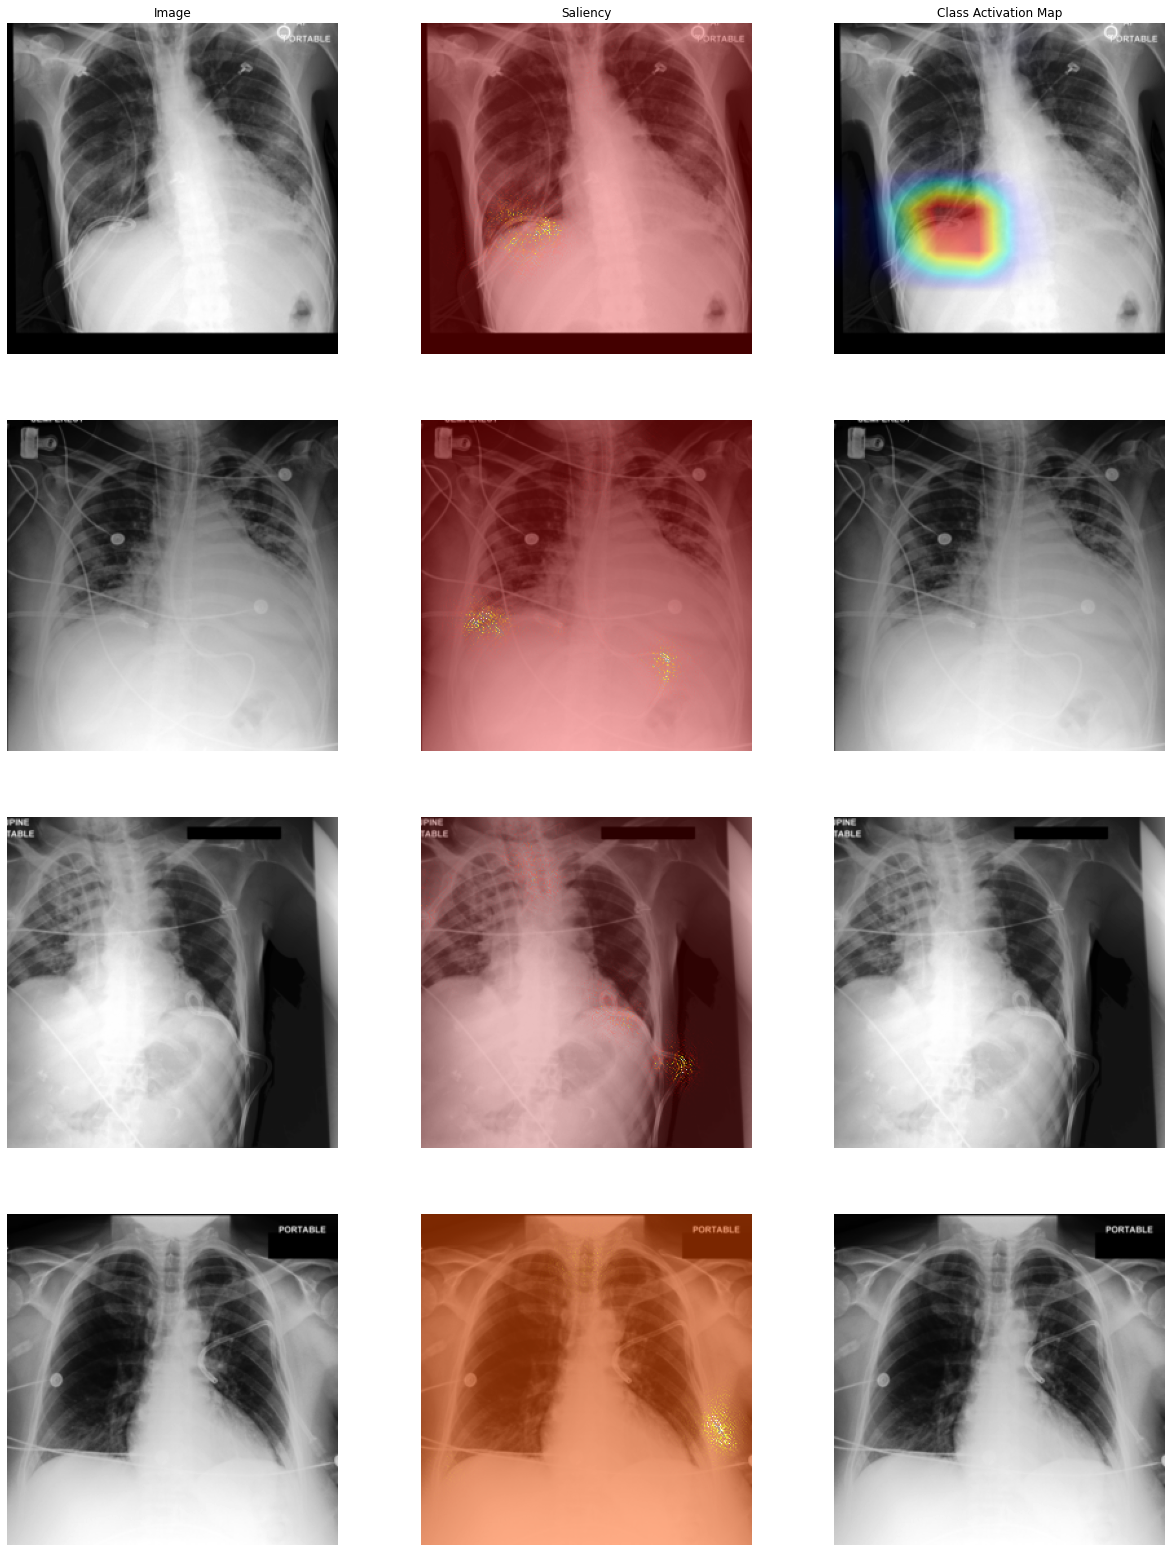



 False Positives


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


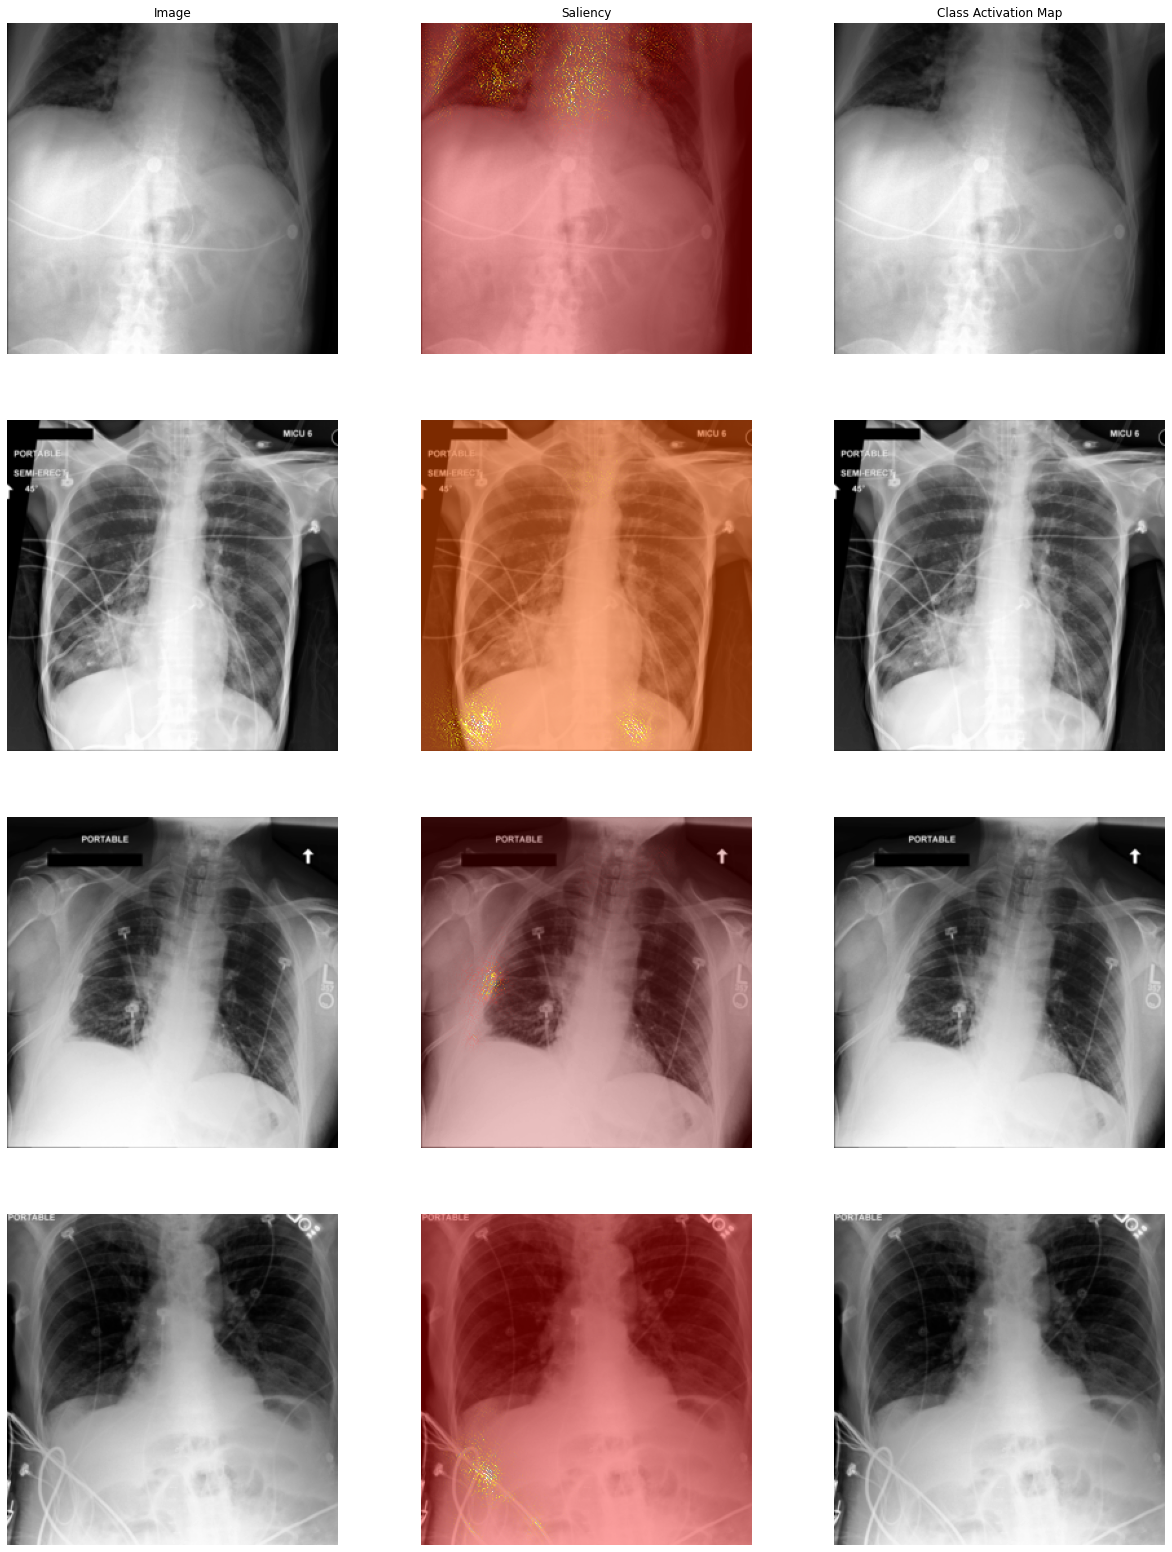



 True Negatives


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


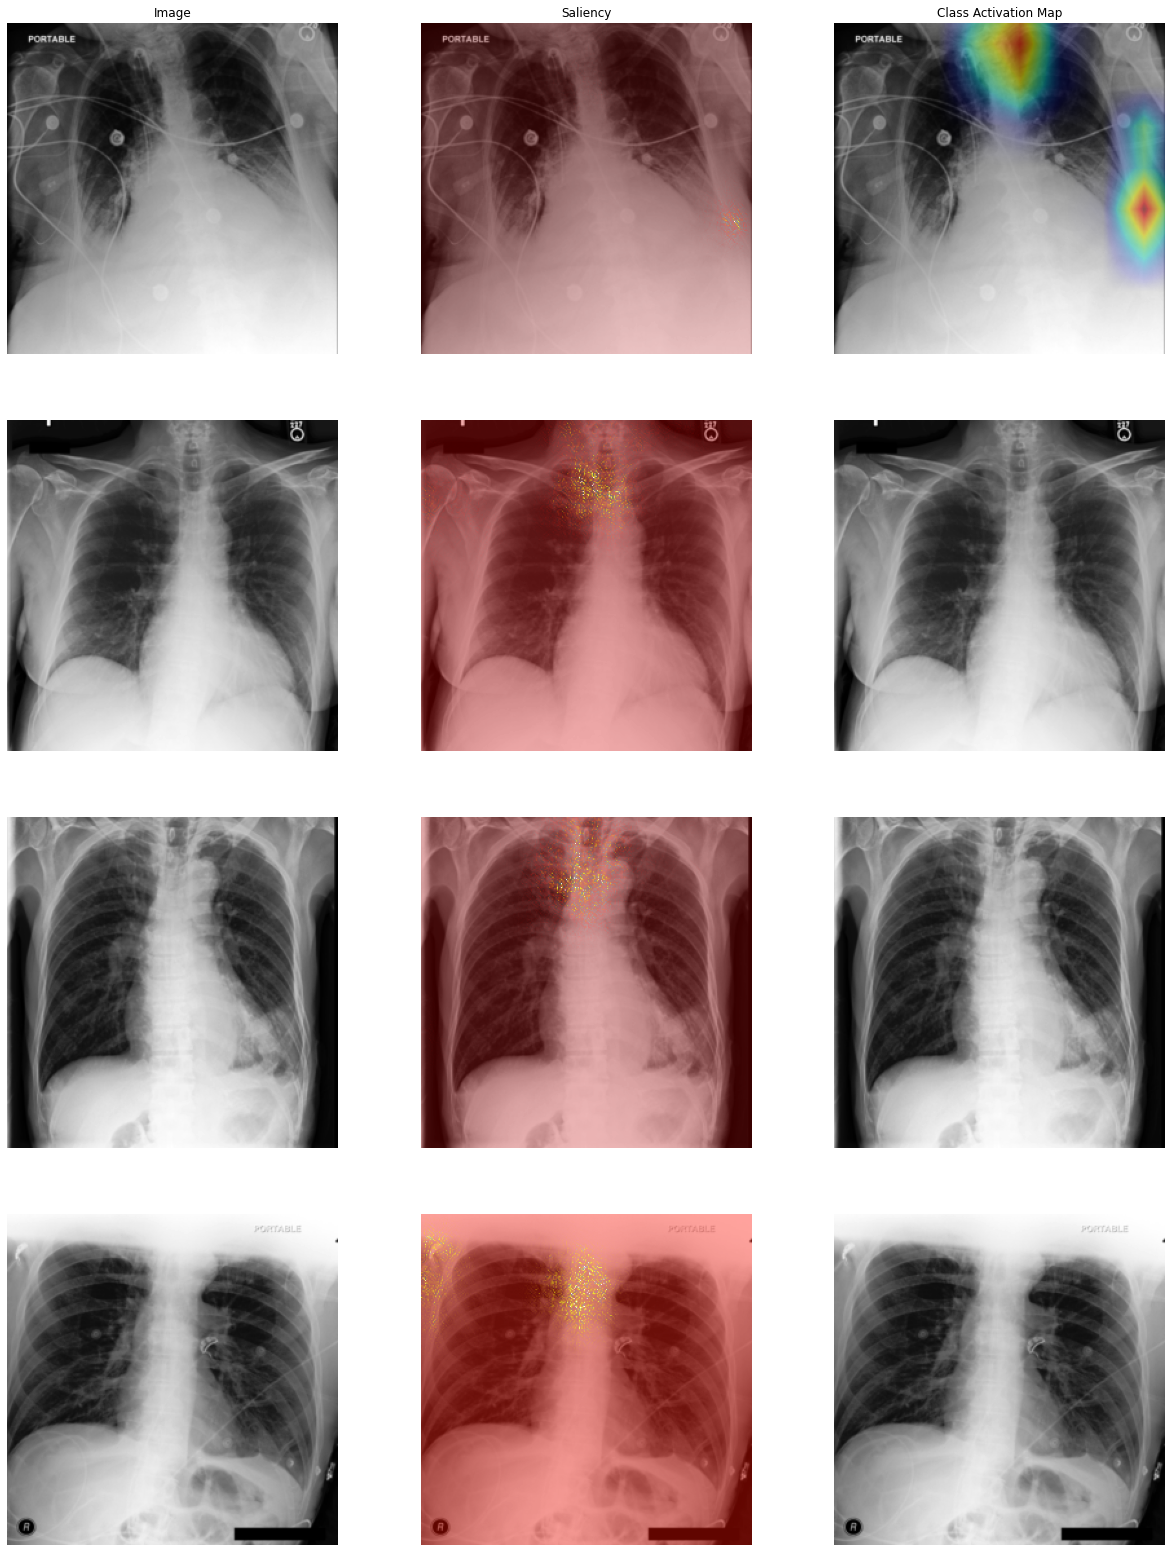



 False Negatives


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


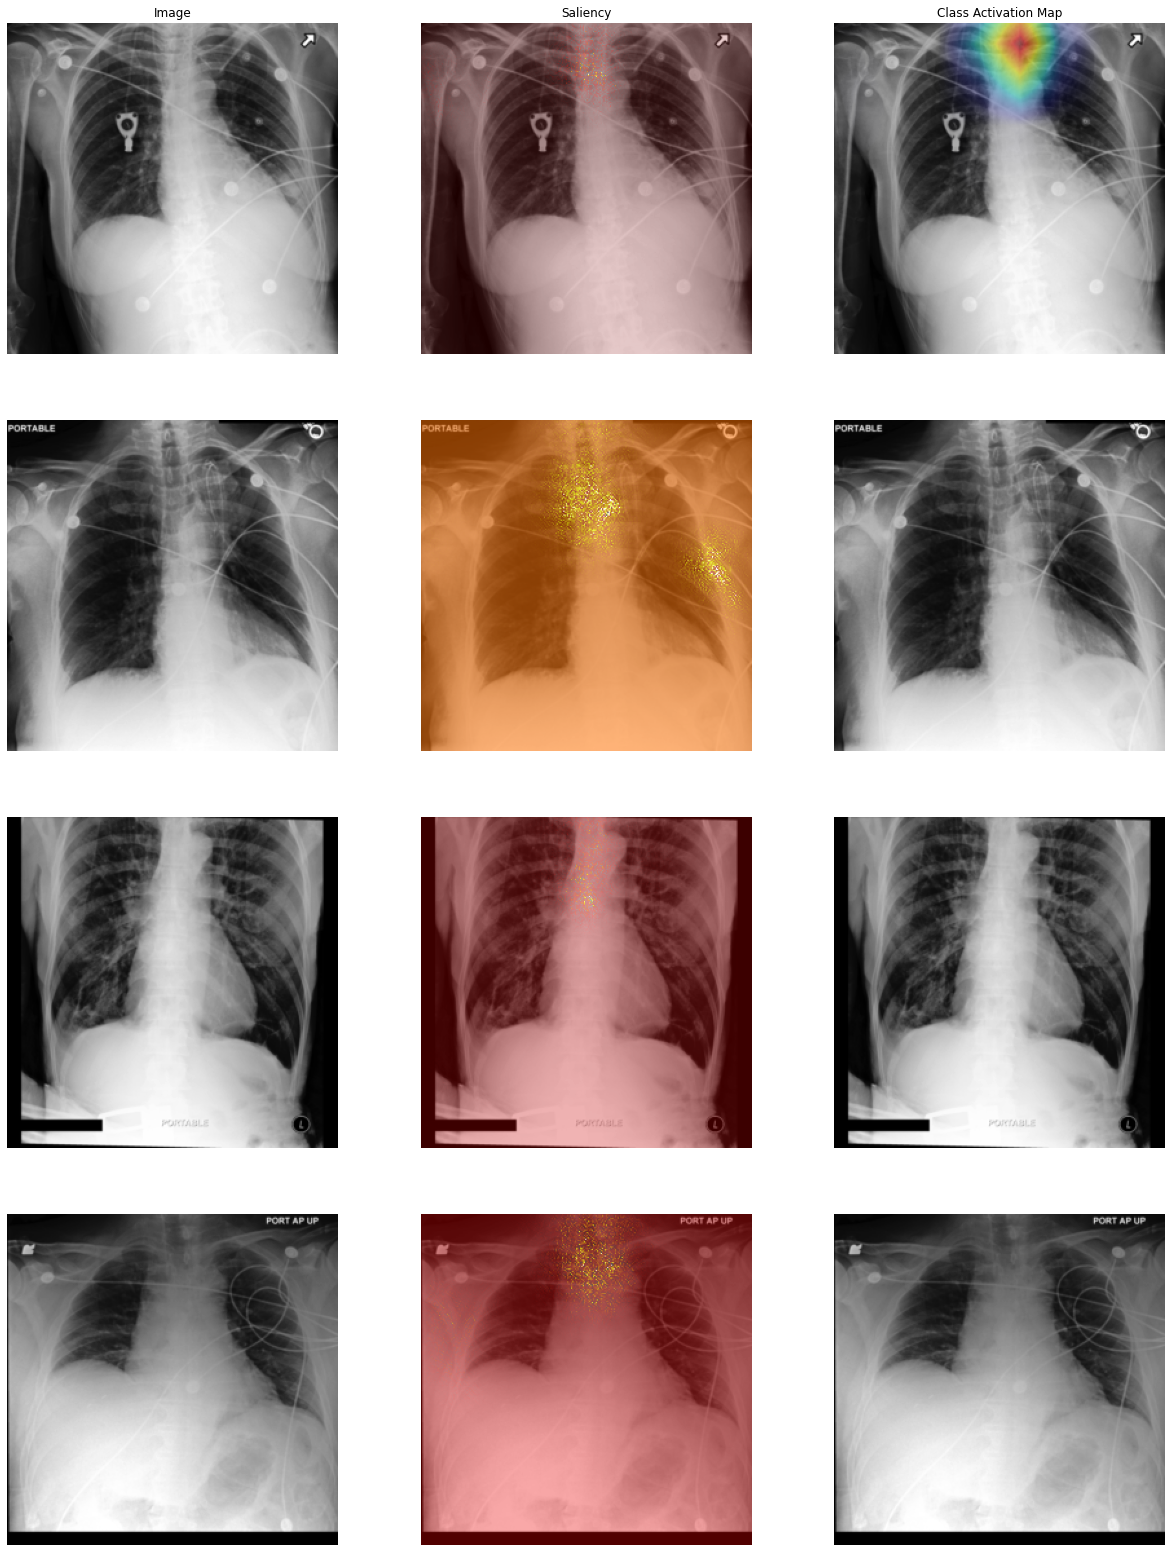

<Figure size 1512x2016 with 0 Axes>

<Figure size 1512x2016 with 0 Axes>

<Figure size 1512x2016 with 0 Axes>

<Figure size 1512x2016 with 0 Axes>

In [0]:
for n, quadrant in [
  ('True Positives', true_positives),
  ('False Positives', false_positives),
  ('True Negatives', true_negatives),
  ('False Negatives', false_negatives),
]:
  print('\n\n', n)
  study_ids = quadrant.index.values
  plot_interpretability_measures(
      model, dataset=dataset, study_ids=study_ids, S=7
  )

#### Write-up Questions
  4. Do these images and the saliency/CAM highlighted regions suggest that the model is learning anything in particular? In particular, does it seem like the concern outlined above, that we may be learning from treatments rather than diagnostic criteria, is valid? Does this model appear to be largely leveraging treatment devices such as pigtail catehters or other chest tubes? Why or why not?
  3. How do these images differ between different error settings?
  4. Are these two methods of visualizing what drives the CNN's predictions identical?

### Leveraging the Radiology Reports

Another oft-understated tool to understand a model's decision making process is to leverage additional, related modalities of data to better explore the underlying data and determine if there are any unexpected confounders in the data. Here, we'll leverage the radiology reports co-released with these images in MIMIC-CXR to do just that.

#### Your Task
In particular, your task will be to compute the frequency of occurrence of every word in these reports and subdivide these counts across the positive samples and negative samples, then compare the two to see what words occur frequently in the positive record reports but less frequently in the negative reports, and vice-versa.

Unlike before, here we aren't giving you any starter code to work with -- your task is just to compare for each word/bigram, the percentage of positive reports (those with `Pneumothorax == 1`) in which that term appears and the percentage of negative reports in which the term appears. 

Include in your code the cells where you do these computations, and the results of what you find, in terms of the most disparately frequent between the two settings.

#### Write-up Questions:
7. What are the top five words that are more frequent in the positive examples than the negative examples? The top five less frequent words?
2. What about the same, but for bigrams?
3. Do these terms appear to be diagnostically relevant to Pneumothorax? Or are they more about other medical concepts? Are there any relationships related to treatments, as we fear?

In [0]:
evaluation_set.head(3)

dicom_id  ...  pred
study_id                                                ...      
50004171  08eb0c93-4cd58454-0669a604-c89aa5a1-6269d526  ...   0.0
50038834  693fa214-5d95622b-04707944-1bccd236-e6776801  ...   0.0
50043346  5c3acc07-43bd0e68-d0e7d732-6df04d50-c4ae8a84  ...   0.0

[3 rows x 6 columns]

In [0]:
all_words = []
pos, neg = [], []
for study_id in evaluation_set.index:
  record = evaluation_set.loc[study_id]
  report = record.report
  report_words = report.strip().split(' ')
  label = record.Pneumothorax
  if label == 1.0:
    pos.extend(report_words)
  if label == 0.0:
    neg.extend(report_words)
  all_words.extend(report_words)

In [0]:
all_cnt, pos_cnt, neg_cnt = Counter(all_words), Counter(pos), Counter(neg)

In [0]:
w_compare = {}
for w, c in all_cnt.items():
  w_compare[w] = pos_cnt[w] - neg_cnt[w] 

In [0]:
pos_freq_words = sorted(w_compare, key=w_compare.get)

In [0]:
pos_freq_words[:-5:-1], pos_freq_words[:5]

(['right', '', 'in', 'pigtail'], ['No', 'no', 'There', 'are', 'pneumothorax.'])

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
all_bigrams = []
pos_bigrams, neg_bigrams = [], []
for study_id in evaluation_set.index:
  record = evaluation_set.loc[study_id]
  report = record.report
  label = record.Pneumothorax
  tokens = nltk.word_tokenize(report)
  bigrams = list(nltk.bigrams(tokens))
  all_bigrams.extend(bigrams)
  if label == 1.0:
    pos_bigrams.extend(bigrams)
  if label == 0.0:
    neg_bigrams.extend(bigrams)  

In [0]:
all_bi_cnt, pos_bi_cnt, neg_bi_cnt = Counter(all_bigrams), Counter(pos_bigrams), Counter(neg_bigrams)
bi_comp = {}
for w, c in all_bi_cnt.items():
  bi_comp[w] = pos_bi_cnt[w] - neg_bi_cnt[w] 
pos_freq_bigrams = sorted(bi_comp, key=bi_comp.get)

In [0]:
pos_freq_bigrams[:-5:-1], pos_freq_bigrams[:5]

([('pigtail', 'catheter'),
  ('chest', 'tube'),
  ('apical', 'pneumothorax'),
  ('the', 'right')],
 [('.', 'No'),
  ('No', 'pneumothorax'),
  ('pneumothorax', '.'),
  ('is', 'no'),
  ('.', 'There')])

### Performance Differences by Treatment Devices Presence

Here, we'll manually extract a subset of patients who have no mention of any of several pneumothorax treatment related terms in their report, then see how well we do on this subset of patients. If we do much worse than we did on the overall set, that will be suggestive of our model being heavily influenced by the confounder of the presence or absence of a treatment. Here are a collection of terms to use. Extract a subset of patients from our overall `evaluation_set` whose reports _do not_ feature _any_ of these terms, then measure the AUROC on just this subset of patients.

Terms to exclude:
  * "drain"
  * "pigtail"
  * "catheter"
  * "tube"
  * "line"
  * "picc"

**Hint:** Pandas has several very useful functions enabled on [string series](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#string-methods) (like our `evaluation_set.report` entries. To access these, you need to use the `.str` accessor on the series. So, for example, lowercase the reports, you could call `evaluation_set.report.str.lower()`, or to see if the text contains the word "bear", you could call `evaluation_set.report.str.contains('bear')`. The former example will return a series of strings containing the lowercased reports, the latter a boolean series containing `True` whenever the report at that index contained the term `'bear'` and `False` otherwise.

**Hint 2:** Recall also that if you wish to take an "`and`" or an "`or`" or pandas series in an elementwise manner, you must use the (normally signifying bitwise) operators `&` (for `and`) and `|` (for `or`). More information can be found [here](https://stackoverflow.com/questions/21415661/logical-operators-for-boolean-indexing-in-pandas/54358361#54358361)

**Hint 3:** Lastly, recall that we've _already computed_ the model's predicted probabilities for _all_ examples in the `evaluation_set`. They can be found in the column `'prob'`.

#### Write-up Questions:
  10. How well does the model do on this subset of patients? Is it significantly worse than on the overall set? What does this suggest about what is guiding our model's performance?

In [0]:
no_treatment_cases = evaluation_set[~evaluation_set.report.str.contains("drain|pigtail|catheter|tube|line|picc", case=False)]

In [0]:
no_treatment_cases.head(2)

dicom_id  ...  pred
study_id                                                ...      
50038834  693fa214-5d95622b-04707944-1bccd236-e6776801  ...   0.0
50281393  b0ccf7f3-cbd90d35-8f94629d-e4515ab1-26ec8352  ...   0.0

[2 rows x 6 columns]

In [0]:
exc_val_auc = roc_auc_score(no_treatment_cases.Pneumothorax, no_treatment_cases.prob)

In [0]:
exc_val_auc

0.5817307692307693

In [0]:

for study_id in evaluation_set.index:
  record = evaluation_set.loc[study_id]
  report = record.report
  for w in excluded:
    if w in report:

  

## Concluding Thoughts / Questions

In this Pset, we analyzed a model for predicting Pneumothorax. With a motivating concern that perhapst he model was confounded by treatment effects visible in the images, we analyzed the model via interpretability methods, text analyses, and stratified performance to determine if it appeared to be significantly confounded by the presence of pigtail catheters or chest drains. Note that this exact problem is a pressing one [in practice](https://arxiv.org/pdf/1909.12475.pdf) (note their analysis of pneumothorax prediction stratified by the presence or absence of a chest drain, albeit on a different dataset than ours).

Building on your work in this PSet, answer the following questions:
  11. Do you think this model is significantly confounded by the presence/absence of treatment devices?
  2. What parts of our analysis pipeline here (e.g., Error Stratification, Saliency Maps, Error Auditing) were most useful? What parts least useful?
  3. When thinking about the visualization methods specifically (e.g., saliency maps), are the assumptions these models make reasonable in their pursuit of offering insight regarding interpretations of our models? For example, Saliency mapping presents one with a heatmap showing how much results would change if pixels were scaled independently of one another, but pixels are in reality highly dependent on their neighbors. Do you think any violations to these assumptions weaken the utility of these methods at all? 
  4. Our labels for Pneumothorax here come from the [CheXpert Labeler](https://github.com/stanfordmlgroup/chexpert-labeler), which automatically annotates chest-xrays with labels via a rule-based classifier that operates on the free-text radiology report. Based on the reports you've looked through here, ignoring any other issues, do our labels for Pneumothorax seem completely noise-free to you?

## Optional Extensions
This section is completely optional, but if you want to extend beyond what you examined in this problem, here are a few interesting directions. **Nothing in this section needs to be completed or turned in or will affect your grade in any capacity.**
1. Can you change our visualization code and your saliency/GradCAM code to take directionality into account? E.g., to highlight pixels differently based on whether increasing or decreasing their value would increase/decrease the probability of the true class? Note you'd need four color-settings here, as you need to worry about pixels that you need to decrease to increase the predicted probability and vice-versa as well as the aligned pairs.
2. We worked specifically with a VGG network here. What about other network types? Is the story as clear using a ResNet? In the provided GCP bucket, we include a `state_dict` for the ResNet model type as well that you can play with.
3. There are lots of other visualization strategies out there. Take a look at https://github.com/utkuozbulak/pytorch-cnn-visualizations for some inspirations--can you implement another option or two for this problem as well, and extend the visualization code to take those into account?